In [1]:
import cv2
import pandas as pd
import numpy as np
from skimage import io
import sys  
cv2.__version__

'4.5.5'

In [2]:
import os, random
#normalization open cv
random_face_group = []
num_picks = 2000
for i in range(num_picks):
    face_str = random.choice(os.listdir('UTKFace'))
    face_str_split = face_str.split('_')
    if(face_str_split[1]=='0'):
        gender = 'male'
    else:
        gender = 'female'
    
    #set race
    if face_str_split[2]=='0':
        race='white'
    elif face_str_split[2]=='1':
        race = 'black'
    elif face_str_split[2]=='2':
        race='asian'
    elif face_str_split[2]=='3':
        race='indian'
    else:
        race='other'
    face_dict = {'gender':gender,'race':race,'path':face_str}
    random_face_group.append(face_dict)

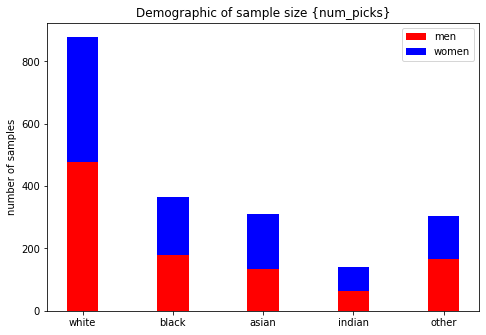

In [3]:
import matplotlib.pyplot as plt

##0: white, 1: black, 2: Asian, 3: Indian, 4: other
men = [0,0,0,0,0]
women = [0,0,0,0,0]
racial_categories = ['white','black','asian','indian','other']

for person in random_face_group:
    race_val = 4
    if person['race']==racial_categories[0]:
        race_val = 0
    elif person['race']==racial_categories[1]:
        race_val = 1
    elif person['race']==racial_categories[2]:
        race_val = 2
    elif person['race']==racial_categories[4]:
        race_val = 3
    
    if person['gender']=='female':
        women[race_val]+=1
    elif person['gender']=='male':
        men[race_val]+=1

num_races = len(racial_categories)
width = 0.35

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ind = np.arange(num_races)

ax.bar(ind,men,width, color='r')
ax.bar(ind,women,width,bottom=men,color='b')
ax.set_ylabel("number of samples")
title = 'Demographic of sample size {num_picks}'
ax.set_title(title)
ax.set_xticks(ind,racial_categories)
ax.legend(['men','women'])

plt.show()

In [7]:
from matplotlib import image
face_df = pd.DataFrame.from_dict(random_face_group)

img_data = {x:0 for x in range(len(face_df))}
for idx, row in face_df.iterrows():
    relative_path = 'UTKFace\\'+str(row["path"])
    img = image.imread(relative_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_data[idx] = gray.flatten()


face_df['img_data'] = pd.Series(img_data)
face_df


,gender,race,path,img_data
0,female,white,16_1_0_20170109213604149.jpg.chip.jpg,"[91, 91, 98, 96, 119, 153, 171, 201, 205, 208,..."
1,female,asian,24_1_2_20170116173716204.jpg.chip.jpg,"[73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 7..."
2,male,indian,57_0_3_20170119183926056.jpg.chip.jpg,"[127, 128, 129, 131, 132, 134, 135, 136, 139, ..."
3,male,white,56_0_0_20170104210832380.jpg.chip.jpg,"[32, 33, 31, 23, 17, 21, 34, 48, 55, 50, 42, 3..."
4,male,indian,6_0_3_20170110213739717.jpg.chip.jpg,"[67, 66, 58, 45, 37, 41, 48, 53, 62, 65, 55, 4..."
...,...,...,...,...
1995,male,indian,45_0_3_20170120222425936.jpg.chip.jpg,"[1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 6, 8, 12, 23, 3..."
1996,male,other,48_0_4_20170104211610652.jpg.chip.jpg,"[86, 87, 89, 90, 91, 90, 89, 88, 84, 78, 69, 6..."
1997,female,black,26_1_1_20170117153641469.jpg.chip.jpg,"[46, 49, 51, 54, 56, 59, 63, 66, 70, 73, 80, 8..."
1998,male,indian,4_0_3_20161220220741730.jpg.chip.jpg,"[65, 61, 53, 42, 32, 28, 31, 34, 22, 23, 24, 2..."


In [27]:
img_data[0].shape

(40000,)

In [29]:
img_mat = np.empty((2000, 40000))
for idx, row in enumerate(img_data):
    img_mat[idx] = img_data[idx]

img_mat.shape


(2000, 40000)

In [36]:
from sklearn.decomposition import PCA
# the default n_components will have PCA build as 
# many compnents as there are features.  this is preferred
# here as we can use our limit_coef param as needed
pca = PCA(n_components=100)
# compress all faces to lower dimensional representation
face_data_compress = pca.fit_transform(img_mat)

In [38]:
# we now have a dataset with 100 eigenface features determined by PCA
face_data_compress[4, :].shape

(100,)

In [40]:
# supply race column vector as our target variable
y = face_df['race'].to_numpy()
# use compressed eigenface data as our training set
X = face_data_compress

In [43]:
from sklearn.model_selection import StratifiedKFold

def cv_clf(clf, X=X, y=y, n_splits=10):
    """
    cross validate passed classifier with k stratified folds
    """
    skfold = StratifiedKFold(n_splits=n_splits)
    y_pred = np.empty_like(y)

    for train_idx, test_idx in skfold.split(X, y):
        X_train = X[train_idx, :]
        X_test = X[test_idx, :]
        y_train = y[train_idx]

        clf.fit(X_train, y_train)

        y_pred[test_idx] = clf.predict(X_test)
        
    return y_pred

In [45]:
from sklearn.linear_model import LogisticRegression
lr_preds = cv_clf(LogisticRegression())

C:\Users\Lilly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lilly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/m

In [46]:

from sklearn.svm import LinearSVC
svc_preds = cv_clf(LinearSVC())

C:\Users\Lilly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Lilly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Lilly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Lilly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed t

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [57]:
pd.Series(y).value_counts()

white     879
black     366
asian     311
indian    305
other     139
dtype: int64

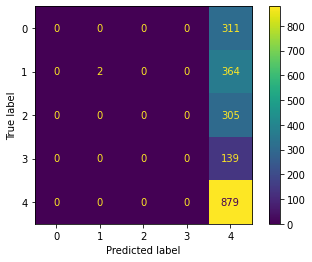

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf_preds = cv_clf(RandomForestClassifier(max_depth=3))
rf_cm = confusion_matrix(y_true=y, y_pred=rf_preds)
ConfusionMatrixDisplay(rf_cm).plot()

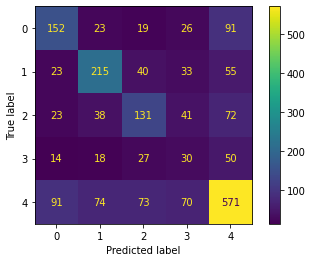

In [59]:
from sklearn.neural_network import MLPClassifier
mlp_preds = cv_clf(MLPClassifier())
mlp_cm = confusion_matrix(y_true=y, y_pred=mlp_preds)
ConfusionMatrixDisplay(mlp_cm).plot()

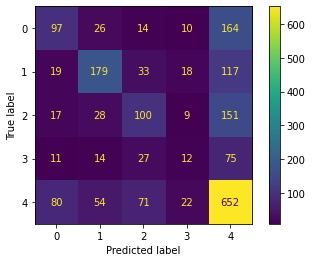

In [60]:
from sklearn.ensemble import AdaBoostClassifier
ada_preds = cv_clf(AdaBoostClassifier())
ada_cm = confusion_matrix(y_true=y, y_pred=ada_preds)
ConfusionMatrixDisplay(ada_cm).plot()